In [1]:
import clusterpy
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from shapely.geometry import Point, box, MultiPoint, Polygon
from sklearn.cluster import KMeans

%matplotlib inline

ClusterPy: Library of spatially constrained clustering algorithms
Some functions are not available, reason: No module named 'Polygon'
Some functions are not available, reason: No module named 'Polygon'


In [2]:
def create_grid(rows, columns, values, plot = False):

    if rows*columns!= len(values):
        print("Size of the list of values does not match with the grid's dimensions!")
        print("The grid will not be created!")
        return 

    length = 10
    wide = 10
    xmin, xmax = 0, columns*wide
    ymin, ymax = 0, rows*wide

    # Create Grid
    cols_pol = list(np.arange(xmin, xmax + wide, wide))
    rows_pol = list(np.arange(ymin, ymax + length, length))
    rows_pol.reverse()
    polygons = []
    for y in rows_pol[:-1]:
        for x in cols_pol[:-1]:
            polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

    grid = gpd.GeoDataFrame({'values': values, 'geometry':polygons})
    
    #Plot
    #plot=True
    if plot: 
        fig, ax = plt.subplots(figsize= (10,10))
        grid.plot('values', ax=ax)
        sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=int(grid["values"].min()), 
                                                                      vmax=int(grid["values"].max())))
        fig.colorbar(sm,ax=ax,shrink=0.75,pad=0.005,label="Values")#format="%2.2f"
        
    return grid

In [3]:
def total_sample_neyman(df, B, group):
    """
    Funcion que calcula el total de puntos a muestrear por region comuna
    usando el método de asignación Neyman

    Args: 
        df (DataFrame): DataFrame con la informacion de los puntos
        muestreados
        B (int): unidades para el error de estimación
        group (str): nombre del grupo que queremos muestrear

    Returns:
        int: número total de muestras necesarias
    """

    numerator = 0
    denominator = 0
    grouped = df.groupby(group)
    for _, grouped_df in grouped:
        numerator += len(grouped_df)*grouped_df['sigma_i'].mean()
        denominator += len(grouped_df)*(grouped_df['sigma_i'].mean())**2
    N = len(df)
    D = B**2 / (4*2)
    n = (numerator**2) / (denominator + (N**2)*D)
    return np.ceil(n)

        

In [4]:
def commune_sample_neyman(df,B,group) -> list:
    """
    Funcion que calcula el total de puntos a muestrear por region comuna
    usando el método de asignación Neyman

    Args: 
        df (DataFrame): DataFrame con la informacion de los puntos
        muestreados
        B (int): unidades para el error de estimación
        group (str): nombre del grupo que queremos muestrear

    Returns:
        list: lista con el número necesario de muestras por comuna
    """
    grouped = df.groupby(group)
    communes_samples = []
    n = total_sample_neyman(df, B,group)
    denominator = 0
    for _,grouped_df in grouped:
        denominator += len(grouped_df)*(grouped_df['sigma_i'].mean())
    for _,grouped_df in grouped:
        numerator = len(grouped_df)*(grouped_df['sigma_i'].mean())
        communes_samples.append(np.ceil(n*numerator/denominator))
    return communes_samples
     

In [5]:
def total_sample_proportional(df, B, group):
    """
    Funcion que calcula el total de puntos a muestrear por region comuna
    usando el método de asignación proporcional

    Args: 
        df (DataFrame): DataFrame con la informacion de los puntos
        muestreados
        B (int): unidades para el error de estimación
        group (str): nombre del grupo que queremos muestrear

    Returns:
        int: número total de muestras necesarias
    """

    numerator = 0
    denominator = 0
    grouped = df.groupby(group)
    for _, grouped_df in grouped:
        numerator += len(grouped_df)*(grouped_df['sigma_i'].mean())**2
        denominator += len(grouped_df)*(grouped_df['sigma_i'].mean())**2
    N = len(df)
    D = B**2 / 4
    n = numerator / (N*D + denominator/N)
    return np.ceil(n)

        

In [6]:
def commune_sample_proportional(df,B,group) -> list:
    """
    Funcion que calcula el total de puntos a muestrear por region comuna
    usando el método de asignación proporcional

    Args: 
        df (DataFrame): DataFrame con la informacion de los puntos
        muestreados
        B (int): unidades para el error de estimación
        group (str): nombre del grupo que queremos muestrear

    Returns:
        list: lista con el número necesario de muestras por comuna
    """
    grouped = df.groupby(group)
    commune_samples = []
    n = total_sample_proportional(df, B,group)
    denominator = 0
    N = len(df)
    for _,grouped_df in grouped:
        commune_samples.append(np.ceil(n*len(grouped_df)/N))
    return commune_samples
     

In [15]:
def simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l, allocation,T=100,B=0.1,plot=False):
    #rows = 10
    #columns = 10
    #rho = 0.99999 # no puede ser 1 o -1 por error algebraico
    # Generacion de Grid fxc con Variable simulada con distribucion SAR(rho)
    shape = clusterpy.createGrid(rows, columns)
    shape.generateData("SAR", "rook", 1, rho)
    #values = np.random.randint(low=0, high=100, size=rows*columns).tolist()
    grid = create_grid(rows, columns, [i[-1] for i in shape.Y.values()], plot = False)

    #N=10000
    # Generacion de N puntos aleatoriamente uniformes en el espacio
    Xs = np.random.uniform(grid.bounds["minx"].min(), grid.bounds["maxx"].max(), N)
    Ys = np.random.uniform(grid.bounds["miny"].min(), grid.bounds["maxy"].max(), N)
    lista_coords = list(zip(Xs, Ys))
    lista_puntos = [Point(x, y) for x, y in lista_coords] 
    gdf_points = gpd.GeoDataFrame(list(range(len(lista_puntos))), geometry=lista_puntos, crs=grid.crs)

    #l = 5
    # Calculo de Comunas usando Kmeans y aplicar formula d n_k
    kmeans = KMeans(n_clusters=l, random_state=0).fit(list(zip(grid.centroid.x,grid.centroid.y)) )
    grid.loc[:,"comuna"] = kmeans.labels_
    print(len(gdf_points),len( kmeans.labels_))
    #comunas.loc[2, "sigma_i"] =  grid[grid["comuna"]==2]["values"].std() #1,2,3,4,5
    comunas = grid.dissolve("comuna")
    for i in range(l):    comunas.loc[i, "sigma_i"] =  grid[grid["comuna"]==i]["values"].std()
    gdf_points_comunas = gpd.sjoin(gdf_points,comunas)
    gdf_points_comunas = gdf_points_comunas.rename(columns = {"index_right":"comuna"})
    Ni_comunas = gdf_points_comunas["comuna"].value_counts()
    comunas.loc[:, "Ni"] = Ni_comunas
    comunas["Si_x_Ni"] = comunas["sigma_i"]*comunas["Ni"]
    #comunas["n_k"] = round(n*(comunas["Si_x_Ni"]/comunas["Si_x_Ni"].sum())).astype(int)

    if allocation == 'neyman':
        # Neyman allocation
        needed_samples = commune_sample_neyman(gdf_points_comunas,B,'comuna')
    elif allocation == 'proportional':
        # Proportional allocation
        needed_samples = commune_sample_proportional(gdf_points_comunas,B,'comuna')
        

    gdf_points_sample = gpd.GeoDataFrame()
    for i in range(len(needed_samples)):
        gdf_points_sample = gdf_points_sample.append(gdf_points_comunas[gdf_points_comunas["comuna"] == i 
            ].sample(n=int(needed_samples[i]))) 
    print('Puntos a muestrear: ' + str(len(gdf_points_sample)))#["Ni"].value_counts()
    #for sample in needed_samples:
    #    print('Puntos a muestrear por comuna: ' + str(sample))

    #Conteo de puntos muestreados por grid   
    gdf_points_sample_comunas = gpd.sjoin(gdf_points_sample,grid)
    gdf_points_sample_comunas = gdf_points_sample_comunas.rename(columns = {"index_right":"grid"})
    n_k =  gdf_points_sample_comunas["grid"].value_counts().sort_index()
    grid["n"] = n_k
    grid["n"] = grid["n"].fillna(0)
    
    #T = 30
    # Calculo de regiones analiticas 
    shape.addVariable("n",grid["n"] )
    #shape.addVariable("n",prop ) #shape.Y
    shape.cluster('maxpTabu', ['SAR1','n'], threshold=T, dissolve=1)
    grid["region_analitica"] = [i[-1] for i in shape.Y.values()]
    poligonos_RA  = grid.dissolve("region_analitica")

    #Plot
    #plot=True
    if plot: 
        fig, ax = plt.subplots(figsize= (16,16))
        grid.plot('values', ax=ax, alpha = 0.6)
        sm = plt.cm.ScalarMappable(cmap='viridis',norm=plt.Normalize(vmin=int(grid["values"].min()), vmax=int(grid["values"].max())))
        fig.colorbar(sm,ax=ax,shrink=0.75,pad=0.005,label="Values")#format="%2.2f"
        gdf_points.plot(ax=ax, markersize = 0.25, color = "black")
        gdf_points_sample.plot("comuna",ax=ax,)
        comunas.plot( ax=ax, facecolor = 'None', edgecolor = 'black', lw =4)
        poligonos_RA.plot(facecolor = 'None', edgecolor = 'red', ax=ax, lw =2)

    return grid, gdf_points, comunas,gdf_points_comunas, gdf_points_sample, poligonos_RA,needed_samples

In [8]:
rows = 15 # numero de filas de la grilla
columns = 15 # numero de columnas de la grilla
rho = 0.9 # Valor de coeficiente rho para Autocorrelacion espacial.
              # no puede ser 1 o -1 por error algebraico
N = 1000 # Numero de puntos total o poblacion
#n = 1000 # Numero de puntos a muestrear de N 
allocation = 'neyman' # 'neyman' or 'proportional'
l = 4 # numero de comunas
T = 30 # Thershold para el max_p
plot = True # Muestra el grafico con todas los datos generados
grid, gdf_points, comunas,gdf_points_comunas, gdf_points_sample, poligonos_RA,needed_sample = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,T)

Creating grid
Done
Generating SAR
Done [SAR]
1000 225
Puntos a muestrear: 699
Puntos a muestrear por comuna: 185.0
Puntos a muestrear por comuna: 161.0
Puntos a muestrear por comuna: 228.0
Puntos a muestrear por comuna: 125.0
Adding variables
Done
Getting variables
Variables successfully extracted
Running max-p-regions model (Duque, Anselin and Rey, 2010)
Local search method: Tabu Search
Number of areas:  225
threshold value:  30
FINAL SOLUTION:  [18, 18, 18, 16, 16, 16, 16, 12, 12, 14, 14, 14, 14, 14, 14, 18, 18, 18, 16, 16, 12, 12, 12, 12, 14, 14, 14, 14, 14, 4, 6, 18, 18, 16, 12, 12, 12, 12, 12, 4, 4, 4, 14, 4, 4, 6, 6, 16, 16, 19, 19, 19, 12, 12, 10, 4, 4, 4, 4, 4, 6, 0, 19, 19, 19, 19, 19, 10, 12, 10, 4, 4, 4, 4, 4, 6, 0, 0, 0, 19, 0, 19, 10, 10, 10, 10, 10, 10, 4, 4, 6, 3, 3, 0, 0, 0, 0, 9, 9, 9, 10, 9, 10, 9, 9, 6, 6, 3, 3, 3, 3, 1, 1, 1, 9, 9, 9, 9, 9, 9, 6, 3, 3, 11, 3, 13, 13, 1, 1, 1, 9, 9, 17, 9, 17, 11, 11, 3, 11, 3, 13, 13, 1, 1, 1, 1, 17, 17, 9, 17, 11, 11, 11, 11, 11, 1

In [ ]:
cells = [(10,10),(15,15),(20,20)]
rho = [-0.9,0,0.9]
N = [50000,100000,150000]
l = [5,10,15]
allocation = ['neyman','proportional']
T = [25,30,50,100,150]
results = []
for cell in cells:
    for r in rho:
        for n in N:
            for ll in l:
                for a in allocation:
                    for t in T:
                        grid, gdf_points, comunas,gdf_points_comunas, gdf_points_sample, poligonos_RA = \
                        simulate_sample_of_poblation_by_stratum(cell[0], cell[1], r, n, ll,a,t,plot=False)
                        regions = []
                        for index, geo in grid.iterrows():
                            analytic_region = geo.geometry
                            for index,sample in gdf_points_sample.iterrows():
                                if analytic_region.contains(sample.geometry):
                                    regions.append(geo.region_analitica)
                        gdf_points_sample['region'] = regions
                        needed_sample = commune_sample_neyman(gdf_points_sample,0.1,'region')
                        results.append([cell[0],cell[1],r,n,ll,a,t,gdf_points_sample,needed_sample,t/(cell[0]*cell[1]),len(poligonos_RA)/(cell[0]*cell[1])])


In [41]:
import pandas as pd

df = pd.DataFrame(results,columns=['rows','columns','rho','N','l','allocation','T','gdf_points_sample','needed_sample','T/(rows*columns)','RA/(rows*columns)'])
df

,rows,columns,rho,N,l,allocation,T,gdf_points_sample,needed_sample,T/(rows*columns),RA/(rows*columns)
0,10,10,-0.9,50000,5,neyman,25,0 geometry comuna ...,"[26.0, 24.0, 26.0, 28.0, 26.0, 30.0, 31.0, 30....",0.2500,1.0000
1,10,10,-0.9,50000,5,neyman,30,0 geometry comuna ...,"[11.0, 13.0, 12.0, 13.0, 12.0, 21.0, 16.0, 15....",0.3000,0.5900
2,10,10,-0.9,50000,5,neyman,50,0 geometry comuna ...,"[27.0, 17.0, 21.0, 18.0, 18.0, 24.0, 18.0, 17....",0.5000,0.5400
3,10,10,-0.9,50000,5,neyman,100,0 geometry comuna ...,"[68.0, 71.0, 68.0, 62.0, 55.0, 63.0, 63.0, 64....",1.0000,0.1400
4,10,10,-0.9,50000,5,neyman,150,0 geometry comuna ...,"[239.0, 142.0, 147.0, 120.0, 165.0, 61.0, 143....",1.5000,0.2100
...,...,...,...,...,...,...,...,...,...,...,...
624,20,20,-0.9,150000,15,neyman,150,0 geometry comun...,"[149.0, 136.0, 117.0, 100.0, 94.0, 128.0, 89.0...",0.3750,0.0250
625,20,20,-0.9,150000,15,proportional,25,0 geometry comun...,"[12.0, 33.0, 15.0, 24.0, 24.0, 14.0, 12.0, 12....",0.0625,0.1750
626,20,20,-0.9,150000,15,proportional,30,0 geometry comun...,"[49.0, 19.0, 23.0, 23.0, 28.0, 20.0, 18.0, 15....",0.0750,0.1850
627,20,20,-0.9,150000,15,proportional,50,0 geometry comun...,"[60.0, 31.0, 38.0, 74.0, 37.0, 38.0, 54.0, 32....",0.1250,0.0725


In [11]:
# results to csv
df.to_csv('experimentation.csv')

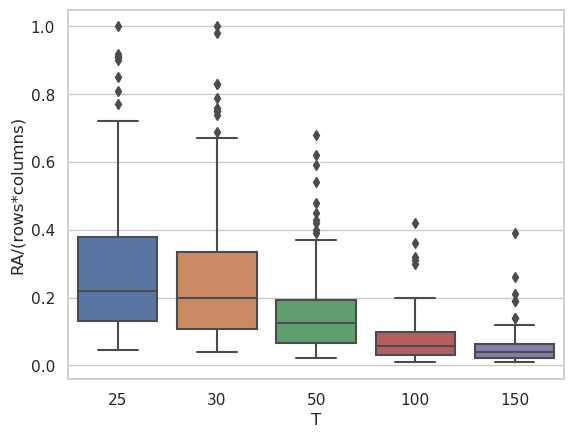

In [13]:
# box plot per T
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
ax = sns.boxplot(x="T", y="RA/(rows*columns)", data=df)
plt.show()

In [75]:
# get all samples for each T and rho from needed samples
cells = [(10,10),(15,15),(20,20)]
rho = [-0.9,0,0.9]
N = [50000,100000,150000]
l = [5,10,15]
allocation = ['neyman','proportional']
T = [25,30,50,100,150]
samples = []
for t in T:
    for r in rho:
         df_samples = df[(df['T'] == t) & (df['rho'] == r)].needed_sample
         for i in df_samples:
                a = i.replace('[','').replace(']','').split(',')
                b = list(map(float,a))
                for l in b:
                        samples.append([l,t,r])

In [78]:
# samples to df
df_samples2 = pd.DataFrame(samples,columns=['sample','T','rho'])
df_samples2.to_csv('samples.csv')

In [24]:
df = df_samples

In [23]:
# samples to dataframe
import pandas as pd
df_samples = pd.read_csv('experimentation.csv')#pd.DataFrame(samples,columns=['sample','T','rho'])
df_samples

,Unnamed: 0,rows,columns,rho,N,l,allocation,T,gdf_points_sample,needed_sample,T/(rows*columns),RA/(rows*columns)
0,0,10,10,-0.9,50000,5,neyman,25,0 geometry comuna ...,"[26.0, 24.0, 26.0, 28.0, 26.0, 30.0, 31.0, 30....",0.2500,1.0000
1,1,10,10,-0.9,50000,5,neyman,30,0 geometry comuna ...,"[11.0, 13.0, 12.0, 13.0, 12.0, 21.0, 16.0, 15....",0.3000,0.5900
2,2,10,10,-0.9,50000,5,neyman,50,0 geometry comuna ...,"[27.0, 17.0, 21.0, 18.0, 18.0, 24.0, 18.0, 17....",0.5000,0.5400
3,3,10,10,-0.9,50000,5,neyman,100,0 geometry comuna ...,"[68.0, 71.0, 68.0, 62.0, 55.0, 63.0, 63.0, 64....",1.0000,0.1400
4,4,10,10,-0.9,50000,5,neyman,150,0 geometry comuna ...,"[239.0, 142.0, 147.0, 120.0, 165.0, 61.0, 143....",1.5000,0.2100
...,...,...,...,...,...,...,...,...,...,...,...,...
624,624,20,20,-0.9,150000,15,neyman,150,0 geometry comun...,"[149.0, 136.0, 117.0, 100.0, 94.0, 128.0, 89.0...",0.3750,0.0250
625,625,20,20,-0.9,150000,15,proportional,25,0 geometry comun...,"[12.0, 33.0, 15.0, 24.0, 24.0, 14.0, 12.0, 12....",0.0625,0.1750
626,626,20,20,-0.9,150000,15,proportional,30,0 geometry comun...,"[49.0, 19.0, 23.0, 23.0, 28.0, 20.0, 18.0, 15....",0.0750,0.1850
627,627,20,20,-0.9,150000,15,proportional,50,0 geometry comun...,"[60.0, 31.0, 38.0, 74.0, 37.0, 38.0, 54.0, 32....",0.1250,0.0725


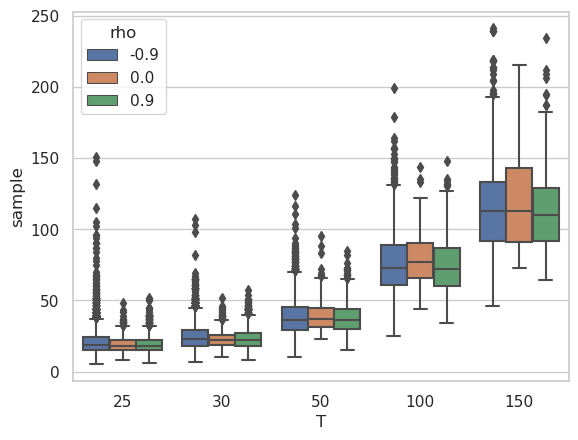

In [46]:
# box plot per T and rho
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
ax = sns.boxplot(x="T", y="sample", hue="rho", data=df_samples)

In [32]:
# samples to dataframe
df_samples = pd.DataFrame(df_samples,columns=['needed_sample','T','rho'])
df_samples

,needed_sample,T,rho
0,"[26.0, 24.0, 26.0, 28.0, 26.0, 30.0, 31.0, 30....",25,-0.9
1,"[11.0, 13.0, 12.0, 13.0, 12.0, 21.0, 16.0, 15....",30,-0.9
2,"[27.0, 17.0, 21.0, 18.0, 18.0, 24.0, 18.0, 17....",50,-0.9
3,"[68.0, 71.0, 68.0, 62.0, 55.0, 63.0, 63.0, 64....",100,-0.9
4,"[239.0, 142.0, 147.0, 120.0, 165.0, 61.0, 143....",150,-0.9
...,...,...,...
624,"[149.0, 136.0, 117.0, 100.0, 94.0, 128.0, 89.0...",150,-0.9
625,"[12.0, 33.0, 15.0, 24.0, 24.0, 14.0, 12.0, 12....",25,-0.9
626,"[49.0, 19.0, 23.0, 23.0, 28.0, 20.0, 18.0, 15....",30,-0.9
627,"[60.0, 31.0, 38.0, 74.0, 37.0, 38.0, 54.0, 32....",50,-0.9


In [54]:
a = df_samples.iloc[0].needed_sample.replace('[','').replace(']','').split(',')
list(map(float,a))

[26.0,
 24.0,
 26.0,
 28.0,
 26.0,
 30.0,
 31.0,
 30.0,
 28.0,
 33.0,
 20.0,
 26.0,
 21.0,
 33.0,
 24.0,
 27.0,
 21.0,
 24.0,
 23.0,
 18.0,
 15.0,
 22.0,
 21.0,
 20.0,
 18.0,
 18.0,
 23.0,
 27.0,
 22.0,
 24.0,
 21.0,
 40.0,
 36.0,
 38.0,
 37.0,
 32.0,
 38.0,
 47.0,
 40.0,
 52.0,
 31.0,
 42.0,
 38.0,
 47.0,
 47.0,
 32.0,
 41.0,
 47.0,
 40.0,
 42.0,
 32.0,
 27.0,
 37.0,
 41.0,
 38.0,
 48.0,
 44.0,
 57.0,
 68.0,
 67.0,
 30.0,
 22.0,
 22.0,
 21.0,
 26.0,
 20.0,
 41.0,
 38.0,
 34.0,
 42.0,
 20.0,
 20.0,
 24.0,
 16.0,
 20.0,
 40.0,
 42.0,
 44.0,
 39.0,
 40.0,
 22.0,
 20.0,
 26.0,
 24.0,
 23.0,
 38.0,
 40.0,
 49.0,
 41.0,
 31.0,
 19.0,
 19.0,
 22.0,
 24.0,
 27.0,
 42.0,
 50.0,
 44.0,
 39.0,
 50.0]

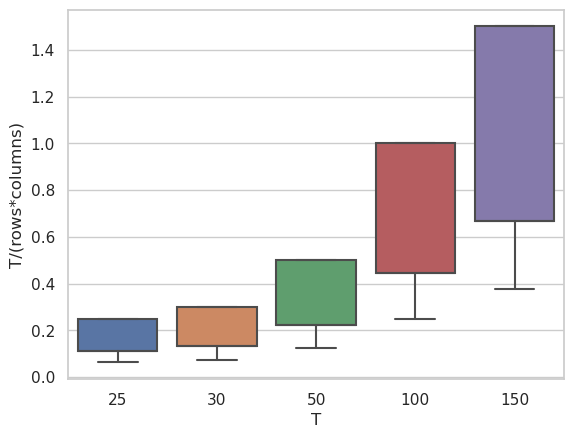

In [15]:
# box plot per T
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
ax = sns.boxplot(x="T", y="T/(rows*columns)", data=df)
plt.show()

In [ ]:
# box plot per T
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
ax = sns.boxplot(x="T", y="RA/(rows*columns)", data=df)

In [ ]:
# greedy algorithm to find best threshold
def best_threshold(df):
    df = df.sort_values(by=['T/(rows*columns)'])
    df['error'] = df['needed_sample'] - df['gdf_points_sample'].apply(lambda x: len(x))
    df['error'] = df['error'].abs()
    df = df.sort_values(by=['error'])
    return df.iloc[0]

In [19]:
samples_df = pd.DataFrame(samples,columns=['sample','T','rho'])

In [87]:
rho_09 = df_samples2[df_samples2['rho'] == 0.9]

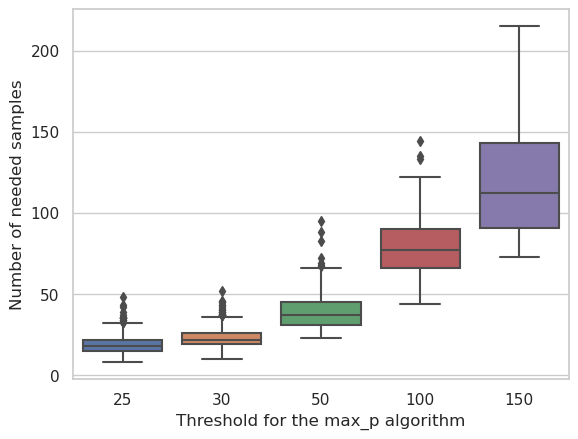

In [107]:
# boxplot per T
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
ax = sns.boxplot(x="T", y="sample", data=rho_09)
# change x axis name and y axis name
plt.xlabel('Threshold for the max_p algorithm')
plt.ylabel('Number of needed samples')
plt.show()

In [ ]:
rho = 0.99
rows = 20
columns = 20
N = 150000
l = 10
allocation = 'neyman'
T = 100
grid, gdf_points, comunas,gdf_points_comunas, gdf_points_sample, poligonos_RA,needed_samples = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,T)
regions = []
for index, geo in grid.iterrows():
        analytic_region = geo.geometry
        for index,sample in gdf_points_sample.iterrows():
                if analytic_region.contains(sample.geometry):
                        regions.append(geo.region_analitica)
gdf_points_sample['region'] = regions
needed_sample_ra = commune_sample_neyman(gdf_points_sample,0.1,'region')

In [28]:
# check if needed_sample_ra less than T
(np.array(needed_sample_ra) < T)

array([ True, False, False,  True,  True,  True,  True, False, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True, False, False,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

Creating grid
Done
Generating SAR
Done [SAR]
10000 400
Puntos a muestrear: 1074
Puntos a muestrear por comuna: 99.0
Puntos a muestrear por comuna: 109.0
Puntos a muestrear por comuna: 74.0
Puntos a muestrear por comuna: 138.0
Puntos a muestrear por comuna: 99.0
Puntos a muestrear por comuna: 120.0
Puntos a muestrear por comuna: 100.0
Puntos a muestrear por comuna: 140.0
Puntos a muestrear por comuna: 115.0
Puntos a muestrear por comuna: 80.0
Adding variables
Done
Getting variables
Variables successfully extracted
Running max-p-regions model (Duque, Anselin and Rey, 2010)
Local search method: Tabu Search
Number of areas:  400
threshold value:  40
FINAL SOLUTION:  [17, 17, 17, 17, 17, 17, 5, 5, 5, 5, 13, 13, 13, 13, 13, 13, 4, 4, 4, 4, 17, 17, 17, 17, 17, 17, 5, 5, 5, 5, 5, 13, 13, 13, 13, 13, 13, 13, 4, 4, 17, 17, 11, 17, 17, 5, 5, 5, 5, 5, 13, 13, 13, 13, 4, 13, 4, 13, 4, 4, 17, 17, 11, 17, 11, 11, 11, 5, 13, 13, 13, 13, 4, 4, 4, 4, 4, 4, 4, 9, 17, 11, 11, 11, 11, 11, 11, 5, 5, 13, 13,

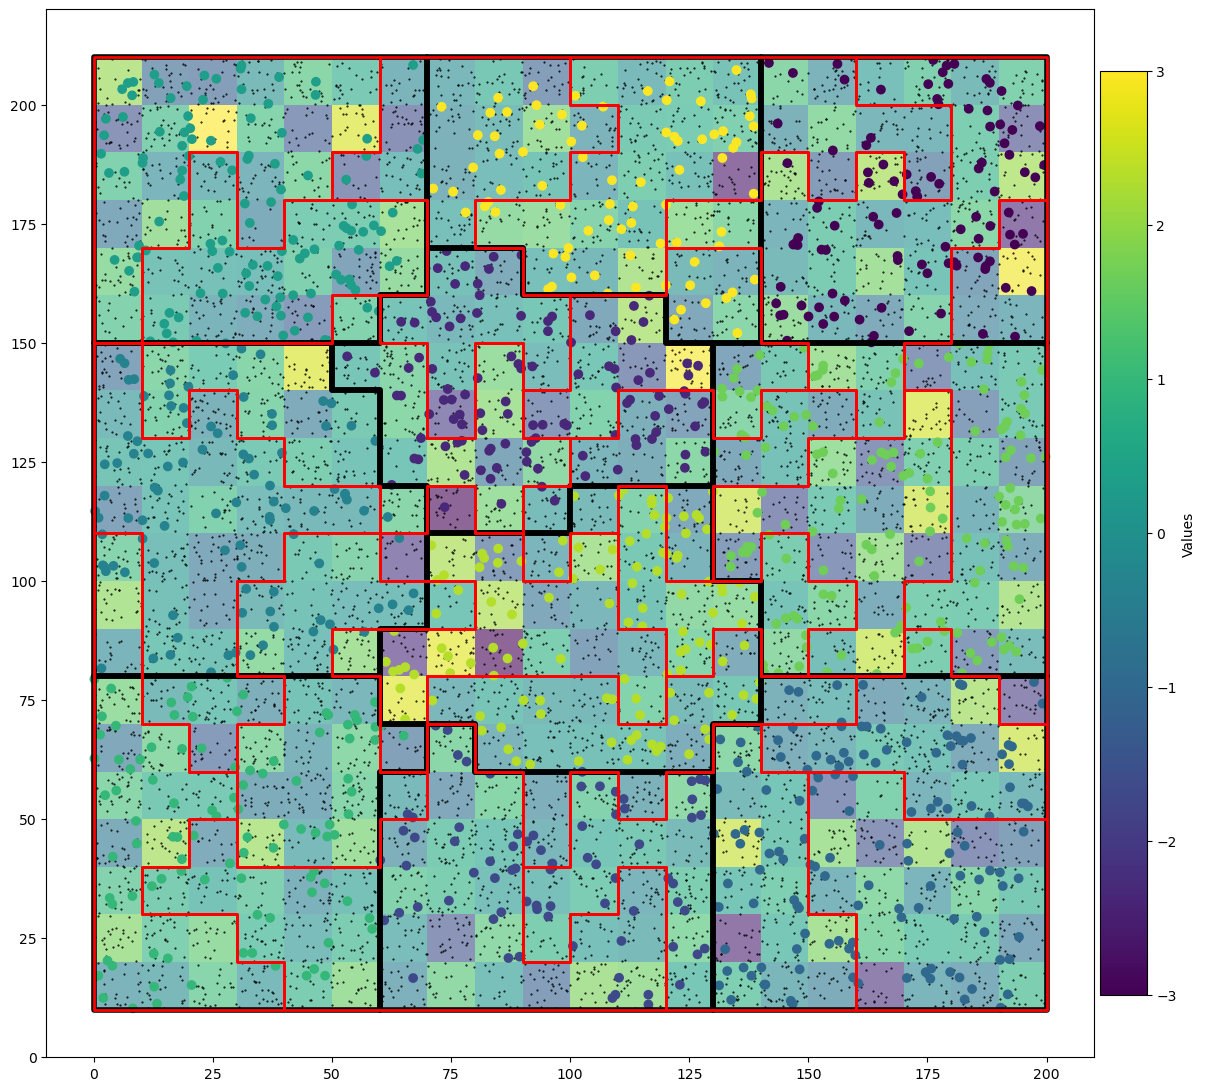

In [56]:
rho = -0.7
rows = 20
columns = 20
N = 10000
l = 10
T = 40
allocation = 'neyman'
grid, gdf_points, comunas,gdf_points_comunas, gdf_points_sample, poligonos_RA,needed_samples = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,T)

In [15]:
gdf_points_sample.reset_index(inplace=True)

In [17]:
geo = gdf_points_sample.geometry

In [18]:
geo

0       POINT (55.421 65.697)
1       POINT (33.629 53.179)
2       POINT (43.406 56.481)
3       POINT (65.893 78.964)
4       POINT (68.669 42.903)
                ...          
730      POINT (7.355 98.707)
731     POINT (18.503 86.511)
732     POINT (11.792 85.964)
733      POINT (2.339 84.704)
734    POINT (25.384 105.080)
Name: geometry, Length: 735, dtype: geometry

In [21]:
geo

0       POINT (55.421 65.697)
1       POINT (33.629 53.179)
2       POINT (43.406 56.481)
3       POINT (65.893 78.964)
4       POINT (68.669 42.903)
                ...          
730      POINT (7.355 98.707)
731     POINT (18.503 86.511)
732     POINT (11.792 85.964)
733      POINT (2.339 84.704)
734    POINT (25.384 105.080)
Name: geometry, Length: 735, dtype: geometry

In [22]:
geo

0       POINT (55.421 65.697)
1       POINT (33.629 53.179)
2       POINT (43.406 56.481)
3       POINT (65.893 78.964)
4       POINT (68.669 42.903)
                ...          
730      POINT (7.355 98.707)
731     POINT (18.503 86.511)
732     POINT (11.792 85.964)
733      POINT (2.339 84.704)
734    POINT (25.384 105.080)
Name: geometry, Length: 735, dtype: geometry

In [27]:
grid1 = grid.geometry[0]
a = np.where(geo.within(grid1)==True)[0]

In [57]:
gdf_points_sample.reset_index(inplace=True)
gdf_points_sample['region'] = 0
points = gdf_points_sample.geometry
for index, geo in grid.iterrows():
    analytic_region = geo.geometry
    belong = np.where(points.within(analytic_region)==True)[0]
    gdf_points_sample.loc[belong,'region'] = geo.region_analitica

In [ ]:
rho = 0.99
rows = 20
columns = 20
N = 150000
l = 10
allocation = 'neyman'
grid, gdf_points, comunas,gdf_points_comunas, gdf_points_sample, poligonos_RA,needed_samples = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation)
gdf_points_sample.reset_index(inplace=True)
gdf_points_sample['region'] = 0
points = gdf_points_sample.geometry
for index, geo in grid.iterrows():
    analytic_region = geo.geometry
    belong = np.where(points.within(analytic_region)==True)[0]
    gdf_points_sample.loc[belong,'region'] = geo.region_analitica
needed_sample_ra = commune_sample_neyman(gdf_points_sample,0.1,'region')

In [9]:
def sample_ra(grid, gdf_points_sample):
    gdf_points_sample.reset_index(inplace=True)
    gdf_points_sample['region'] = 0
    points = gdf_points_sample.geometry
    for index, geo in grid.iterrows():
        analytic_region = geo.geometry
        belong = np.where(points.within(analytic_region)==True)[0]
        gdf_points_sample.loc[belong,'region'] = geo.region_analitica
    needed_sample_ra = commune_sample_neyman(gdf_points_sample,0.1,'region')
    return needed_sample_ra

In [ ]:
rho = 0.0
rows = 20
columns = 20
N = 150000
l = 10
allocation = 'neyman'
T = 700
grid, _, _,_, gdf_points_sample, _,needed_samples = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,T)
high_T = int(0.75*min(needed_samples))
low_T = int(0.05*min(needed_samples))
mid_T = int(0.5*(high_T+low_T))
while (high_T - low_T) >= 0 :
    grid, _, _,_, gdf_points_sample, _,_ = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,high_T)
    needed_sample_high_T = sample_ra(grid, gdf_points_sample)
    if all(sample<high_T for sample in needed_sample_high_T) == True:
        break
    else:
        high_T -= int(0.05*high_T)
    grid, _, _,_, gdf_points_sample, _,needed_samples = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,low_T)
    needed_sample_low_T = sample_ra(grid, gdf_points_sample)
    if all(sample<low_T for sample in needed_sample_low_T) == True:
        break
    else:
        low_T += int(0.05*low_T)
    grid, _, _,_, gdf_points_sample, _,needed_samples = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,mid_T)
    needed_sample_mid_T = sample_ra(grid, gdf_points_sample)
    if all(sample<mid_T for sample in needed_sample_mid_T) == True:
        break
    else:
        mid_T = int(0.5*(high_T+low_T))

In [8]:
def sample_ra(grid, gdf_points_sample):
    gdf_points_sample.reset_index(inplace=True)
    gdf_points_sample['region'] = 0
    points = gdf_points_sample.geometry
    for index, geo in grid.iterrows():
        analytic_region = geo.geometry
        belong = np.where(points.within(analytic_region)==True)[0]
        gdf_points_sample.loc[belong,'region'] = geo.region_analitica
    needed_sample_ra = commune_sample_neyman(gdf_points_sample,0.1,'region')
    return needed_sample_ra

In [9]:
def get_threshold_value(rho,rows,columns,N,l,allocation,T=700):
    grid, _, _,_, gdf_points_sample, _,needed_samples = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,T)
    high_T = int(0.75*min(needed_samples))
    low_T = int(0.05*min(needed_samples))
    mid_T = int(0.5*(high_T+low_T))
    while (high_T - low_T) >= 0 :
        grid, _, _,_, gdf_points_sample, _,_ = \
            simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,high_T)
        needed_sample_high_T = sample_ra(grid, gdf_points_sample)
        if all(sample<high_T for sample in needed_sample_high_T) == True:
            return needed_samples, high_T, needed_sample_high_T,all(sample<high_T for sample in needed_sample_high_T) == True
        else:
            high_T -= int(0.20*high_T)
        grid, _, _,_, gdf_points_sample, _,_ = \
            simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,low_T)
        needed_sample_low_T = sample_ra(grid, gdf_points_sample)
        if all(sample<low_T for sample in needed_sample_low_T) == True:
            return needed_samples, low_T,needed_sample_low_T,all(sample<low_T for sample in needed_sample_low_T) == True
        else:
            low_T += int(0.20*low_T)
        grid, _, _,_, gdf_points_sample, _,_ = \
            simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,mid_T)
        needed_sample_mid_T = sample_ra(grid, gdf_points_sample)
        if all(sample<mid_T for sample in needed_sample_mid_T) == True:
            return needed_samples, mid_T, needed_sample_mid_T, all(sample<mid_T for sample in needed_sample_mid_T) == True
        else:
            mid_T = int(0.5*(high_T+low_T))
    return needed_samples, mid_T, needed_sample_mid_T, False

In [12]:
def get_threshold_value_min_approach(rho,rows,columns,N,l,allocation,T=700):
    grid, _, _,_, gdf_points_sample, _,needed_samples = \
        simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,T)
    max_T = int(0.75*min(needed_samples))
    min_T = 20    
    while (max_T - min_T) >= 0:
        print('------------------------------------------------------------')
        grid, _, _,_, gdf_points_sample, _,_ = \
            simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,min_T)
        needed_sample_T = sample_ra(grid, gdf_points_sample)
        print('Calculating nedeed sample for T = ',min_T)
        if all(sample<min_T for sample in needed_sample_T) == True:
            new_T = int(min_T - 0.05*min_T)
            grid, _, _,_, gdf_points_sample, _,_ = \
            simulate_sample_of_poblation_by_stratum(rows, columns, rho, N, l,allocation,new_T)
            needed_sample_new_T = sample_ra(grid, gdf_points_sample)
            if all(sample<new_T for sample in needed_sample_new_T) == True:
                return needed_samples, new_T, needed_sample_new_T,all(sample<new_T for sample in needed_sample_new_T) == True
        elif (all(sample<min_T for sample in needed_sample_T) == True):
            return needed_samples, min_T, needed_sample_T, all(sample<min_T for sample in needed_sample_T) == True
        else:
            print('---------------------------------------------------------------------')
            min_T += int(0.20*min_T)
            print('Updating T to: ',min_T)
    return needed_samples, min_T, needed_sample_T, False

In [19]:
needed_samples, T,needed_sample_T, is_valid = get_threshold_value_min_approach(0,10,10,10000,10,'neyman')

Creating grid
Done
Generating SAR
Done [SAR]
10000 100
Puntos a muestrear: 633
Puntos a muestrear por comuna: 63.0
Puntos a muestrear por comuna: 75.0
Puntos a muestrear por comuna: 41.0
Puntos a muestrear por comuna: 62.0
Puntos a muestrear por comuna: 92.0
Puntos a muestrear por comuna: 80.0
Puntos a muestrear por comuna: 54.0
Puntos a muestrear por comuna: 38.0
Puntos a muestrear por comuna: 79.0
Puntos a muestrear por comuna: 49.0
Adding variables
Done
Getting variables
Variables successfully extracted


KeyboardInterrupt: 

In [25]:
# values from -0.99 to 0.99 from 0.1 to 0.1
rho_values = np.arange(-0.99,0.99,0.1)
rows = 20
columns = 20
N = 150000
l = 10
allocation = 'neyman'
results = []
for rho in rho_values:
    needed_samples, threshold_value, needed_sample_T,check = get_threshold_value_min_approach(rho,rows,columns,N,l,allocation)
    results.append([rho,needed_samples, threshold_value, needed_sample_T,check])

Creating grid
Done
Generating SAR
Done [SAR]
150000 400
Puntos a muestrear: 48151
Puntos a muestrear por comuna: 4886.0
Puntos a muestrear por comuna: 2337.0
Puntos a muestrear por comuna: 4105.0
Puntos a muestrear por comuna: 11486.0
Puntos a muestrear por comuna: 2891.0
Puntos a muestrear por comuna: 2525.0
Puntos a muestrear por comuna: 5550.0
Puntos a muestrear por comuna: 8269.0
Puntos a muestrear por comuna: 4122.0
Puntos a muestrear por comuna: 1980.0
Adding variables
Done
Getting variables
Variables successfully extracted
Running max-p-regions model (Duque, Anselin and Rey, 2010)
Local search method: Tabu Search
Number of areas:  400
threshold value:  700
FINAL SOLUTION:  [12, 12, 12, 12, 12, 36, 36, 36, 36, 9, 35, 35, 35, 1, 24, 24, 24, 24, 51, 51, 12, 12, 12, 12, 12, 12, 36, 36, 36, 9, 35, 35, 35, 1, 24, 1, 24, 51, 51, 51, 12, 12, 12, 12, 2, 12, 36, 36, 36, 9, 9, 35, 1, 1, 1, 1, 16, 51, 53, 53, 42, 42, 2, 2, 2, 2, 36, 36, 9, 9, 35, 35, 35, 1, 16, 16, 16, 16, 53, 53, 42, 42, 2

In [ ]:
# results to df to csv
import pandas as pd
df_results = pd.DataFrame(results,columns=['rho','needed_samples','threshold_value','needed_sample_T','check'])
df_results.to_csv('threshold_values5.csv')

In [16]:
df_results

,rho,needed_samples,threshold_value,needed_sample_T,check


In [ ]:
needed_samples, threshold_value, needed_sample_T,check = get_threshold_value(0.5,rows,columns,N,l,'proportional')

In [14]:
df = pd.read_csv('threshold_values.csv')
df2 = pd.read_csv('threshold_values2.csv')
df3 = pd.read_csv('threshold_values3.csv')
df5 = pd.read_csv('threshold_values5.csv')

# concat all df
#df = pd.concat([df,df2,df3,df4,df5])
# select only true values
#df = df[df['check']==True]

In [11]:
import pandas as pd
df = pd.read_csv('threshold_values5.csv')

In [12]:
def n_gap_df(df):
    # drop unnamed and reset index
    df.drop('Unnamed: 0',axis=1,inplace=True)
    df.reset_index(inplace=True)
    df.drop('index',axis=1,inplace=True)
    # iterate over rows with iterrows()
    needed_sample_list = []
    needed_sample_T_list = []
    for index, row in df.iterrows():
        change_1 = df.iloc[index].needed_samples.replace('[','').replace(']','').split(',')
        needed_sample_list.append(list(map(float,change_1)))
        change_2 = df.iloc[index].needed_sample_T.replace('[','').replace(']','').split(',')
        needed_sample_T_list.append(list(map(float,change_2)))
    df.needed_samples = needed_sample_list
    df.needed_sample_T = needed_sample_T_list
    # iterate over rows with iterrows()
    N_gap_list = []
    A_gain_list = []
    for index, row in df.iterrows():
        N_gap = (np.mean(df.iloc[index].needed_samples) - np.mean(df.iloc[index].needed_sample_T)) / np.mean(df.iloc[index].needed_samples)
        N_gap_list.append(N_gap)
        A_gain = 1 - len(df.iloc[index].needed_samples) / len(df.iloc[index].needed_sample_T)
        A_gain_list.append(A_gain)
    df['N_gap'] = N_gap_list
    df['A_gain'] = A_gain_list
    return df

In [15]:
df_1 = n_gap_df(df)
df_2 = n_gap_df(df2)
df_3 = n_gap_df(df3)
df_5 = n_gap_df(df5)


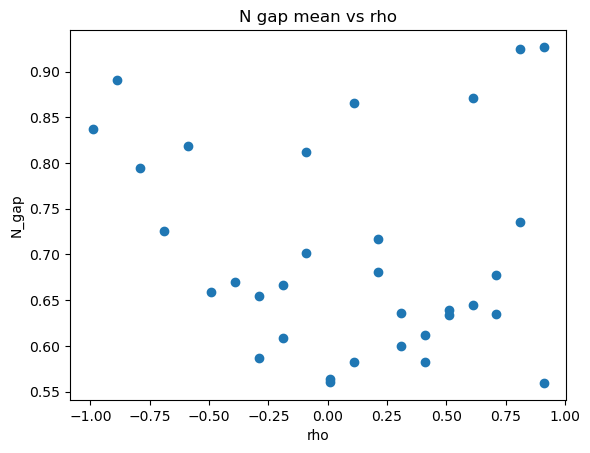

In [22]:
# concat all df
df = pd.concat([df_1,df_2,df_3,df_5])
# mean n_gap and A_gain per rho
df_mean = df.groupby('rho').mean()
# plot n_gap and A_gain per rho
import matplotlib.pyplot as plt
plt.title('N gap mean vs rho')
plt.xlabel('rho')
plt.ylabel('N_gap')
plt.scatter(df_mean.index,df_mean.N_gap)



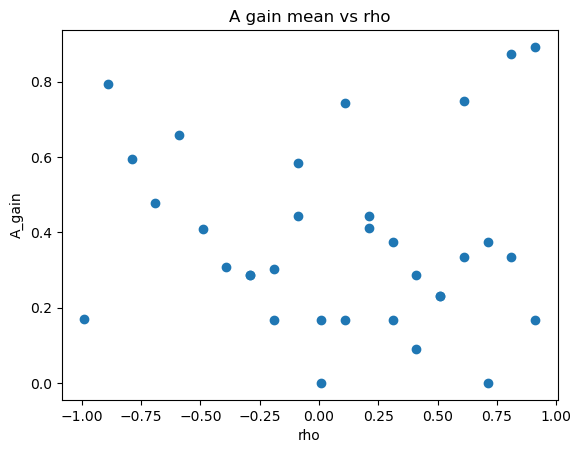

In [23]:
plt.title('A gain mean vs rho')
plt.xlabel('rho')
plt.ylabel('A_gain')
plt.scatter(df_mean.index,df_mean.A_gain)

In [ ]:
# drop unnamed and reset index
df.drop('Unnamed: 0',axis=1,inplace=True)
df.reset_index(inplace=True)
df.drop('index',axis=1,inplace=True)

In [ ]:
# iterate over rows with iterrows()
needed_sample_list = []
needed_sample_T_list = []
for index, row in df.iterrows():
    change_1 = df.iloc[index].needed_samples.replace('[','').replace(']','').split(',')
    needed_sample_list.append(list(map(float,change_1)))
    change_2 = df.iloc[index].needed_sample_T.replace('[','').replace(']','').split(',')
    needed_sample_T_list.append(list(map(float,change_2)))

In [ ]:
df.needed_samples = needed_sample_list
df.needed_sample_T = needed_sample_T_list

In [ ]:
# iterate over rows with iterrows()
N_gap_list = []
A_gain_list = []
for index, row in df.iterrows():
    N_gap = (np.mean(df.iloc[index].needed_samples) - np.mean(df.iloc[index].needed_sample_T)) / np.mean(df.iloc[index].needed_samples)
    N_gap_list.append(N_gap)
    A_gain = 1 - len(df.iloc[index].needed_samples) / len(df.iloc[index].needed_sample_T)
    A_gain_list.append(A_gain)

In [ ]:
df['N_gap'] = N_gap_list
df['A_gain'] = A_gain_list
df

,rho,needed_samples,threshold_value,needed_sample_T,check,N_gap,A_gain
0,-0.99,"[2210.0, 1497.0, 1186.0, 1206.0, 1110.0, 1027....",395,"[175.0, 287.0, 392.0, 274.0, 208.0, 193.0, 328...",True,0.850295,0.565217
1,-0.89,"[325.0, 169.0, 286.0, 350.0, 455.0, 138.0, 366...",83,"[56.0, 50.0, 43.0, 47.0, 44.0, 35.0, 62.0, 43....",True,0.806223,0.642857
2,-0.79,"[170.0, 106.0, 160.0, 237.0, 245.0, 222.0, 160...",52,"[34.0, 48.0, 41.0, 30.0, 32.0, 31.0, 29.0, 36....",True,0.807317,0.600000
3,-0.69,"[117.0, 105.0, 121.0, 217.0, 170.0, 143.0, 161...",78,"[61.0, 48.0, 45.0, 62.0, 48.0, 49.0, 66.0, 59....",True,0.629836,0.333333
4,-0.59,"[104.0, 70.0, 93.0, 128.0, 121.0, 100.0, 96.0,...",34,"[20.0, 20.0, 19.0, 19.0, 29.0, 19.0, 20.0, 19....",True,0.782178,0.629630
5,-0.49,"[81.0, 86.0, 74.0, 102.0, 129.0, 103.0, 124.0,...",55,"[49.0, 28.0, 49.0, 40.0, 53.0, 36.0, 43.0, 41....",True,0.602143,0.285714
6,-0.39,"[79.0, 60.0, 81.0, 97.0, 101.0, 107.0, 93.0, 9...",36,"[33.0, 30.0, 29.0, 33.0, 23.0, 35.0, 23.0, 29....",True,0.710614,0.523810
7,-0.29,"[84.0, 85.0, 86.0, 104.0, 100.0, 76.0, 90.0, 1...",45,"[32.0, 37.0, 23.0, 29.0, 33.0, 40.0, 42.0, 28....",True,0.653827,0.285714
8,-0.19,"[68.0, 79.0, 69.0, 99.0, 103.0, 91.0, 78.0, 12...",45,"[28.0, 33.0, 30.0, 29.0, 42.0, 33.0, 37.0, 29....",True,0.617207,0.230769


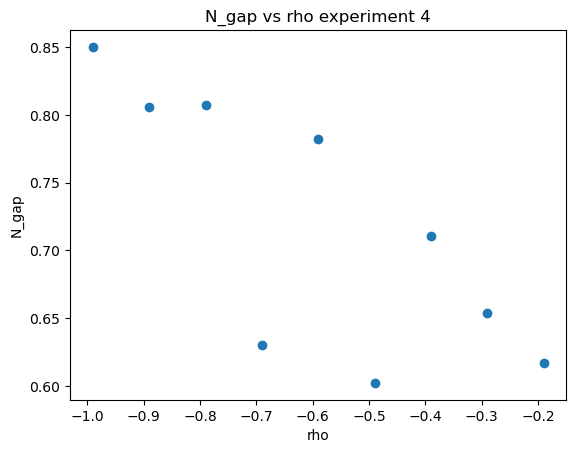

In [ ]:
# plot N_gap vs rho
import matplotlib.pyplot as plt
plt.title('N_gap vs rho experiment 4')
plt.xlabel('rho')
plt.ylabel('N_gap')
plt.scatter(df.rho,df.N_gap)

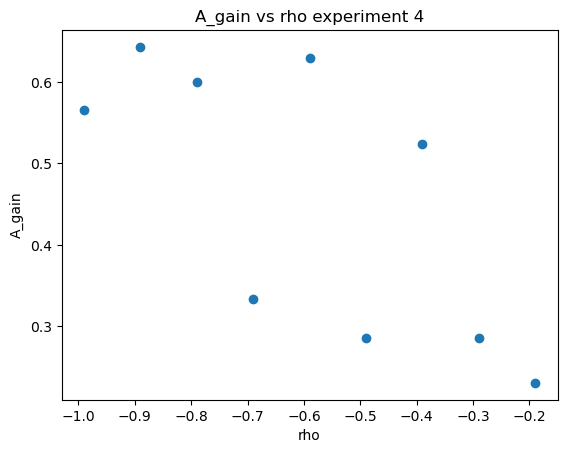

In [ ]:
# plot A_gain vs rho for unique rho values
df2 = df.drop_duplicates(subset=['rho'])
plt.title('A_gain vs rho experiment 4')
plt.xlabel('rho')
plt.ylabel('A_gain')
plt.scatter(df.rho,df.A_gain)